<img src="https://i.ibb.co/jGWqPCJ/banner.png">

# Predict Wind Speeds of Tropical Storms

__Team:__ ______ <br>
__Elements:__   Francisco Costa, João Gouveia, Pedro Rivera

<a class="anchor" id="Table_Contents"></a>
__Table of Contents:__ <br>
* [1. Business Understanding](#business-understanding)
* [2. Data Understanding](#data-understanding)
* [3. Data Preparation](#data-preparation)
* [4. Modeling](#modeling)
* [5. Submission](#submission)

<a class="anchor" id="business-understanding"></a>
## 1. Imports & Configs

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
%matplotlib inline
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import re
from sklearn import metrics

#SEABORN SETTINGS
sns.set_style('darkgrid')

#PANDAS SETTINGS
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

jump_cell = True

In [2]:
selected_device = '/GPU:0'

# with tf.device(selected_device_in):

In [3]:
# general definitions
batch_size = 256
img_width = 32
img_height = 32

In [4]:
training_dir = '../image_data/train'
test_dir = '../image_data/test'

<a class="anchor" id="data-understanding"></a>
## 2. Data Understanding

### 2.1 Features

In [5]:
train_features = pd.read_csv('data/training_set_features.csv')
train_features.head(8)

,image_id,storm_id,relative_time,ocean
0,abs_000,abs,0,2
1,abs_001,abs,1800,2
2,abs_002,abs,5400,2
3,abs_003,abs,17999,2
4,abs_004,abs,19799,2
5,abs_005,abs,32399,2
6,abs_006,abs,34199,2
7,abs_007,abs,37799,2


In [6]:
print('There are {} storms in this training dataset.'.format(train_features['storm_id'].nunique()))

There are 494 storms in this training dataset.


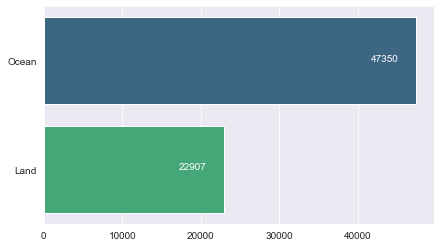

In [7]:
fig, ax = plt.subplots(figsize=(7,4))

ocean_values = train_features['ocean'].value_counts().values

sns.barplot(x=ocean_values,
            y=['Ocean', 'Land'],
            orient='h',
            palette='viridis',
            ax=ax)

for idx, val in enumerate(ocean_values):
    ax.text(x = val - ocean_values.min()*0.25,
            y = idx,
            s = val,
            **dict(size=10, color='white'))
    
plt.show()

### 2.2 Labels

In [8]:
train_labels = pd.read_csv('data/training_set_labels.csv')
train_labels.head()

,image_id,wind_speed
0,abs_000,43
1,abs_001,44
2,abs_002,45
3,abs_003,52
4,abs_004,53


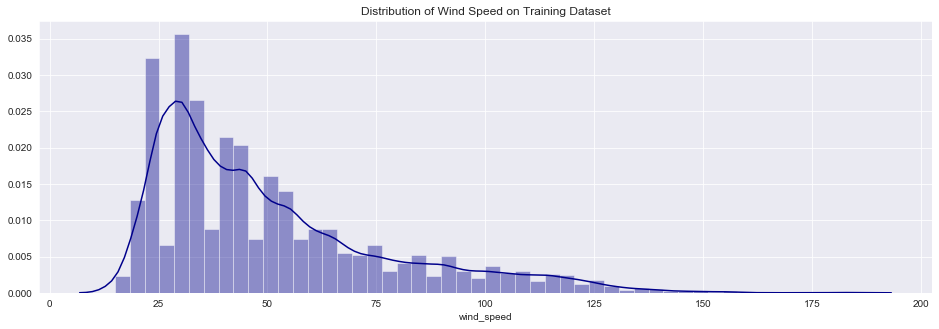

In [9]:
fig, ax = plt.subplots(figsize=(16,5))

plt.title('Distribution of Wind Speed on Training Dataset')
sns.distplot(a=train_labels['wind_speed'],color='darkblue')

plt.show()

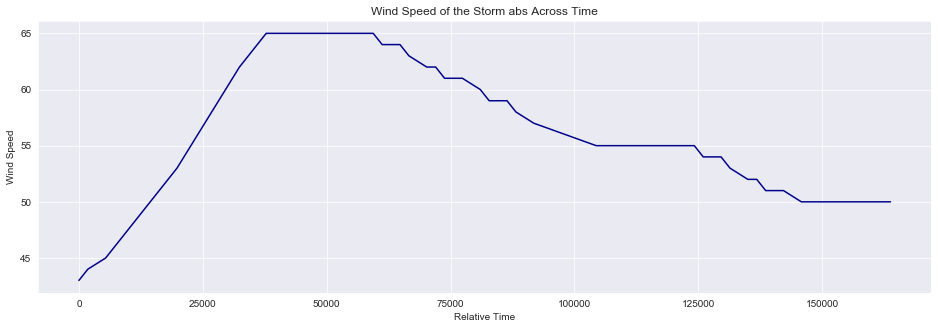

In [10]:
storm_choice = 'abs'

fig, ax = plt.subplots(figsize=(16,5))

time = train_features.loc[train_features['storm_id']==storm_choice]['relative_time'].values
speed = train_labels.loc[train_labels['image_id'].str.contains(storm_choice)]['wind_speed'].values

plt.title('Wind Speed of the Storm {} Across Time'.format(storm_choice))
plt.ylabel('Wind Speed')
plt.xlabel('Relative Time')
sns.lineplot(x=time, y=speed, color='darkblue')

plt.show()


### 2.3 Images

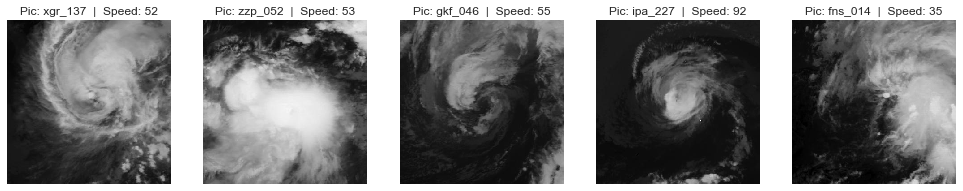

In [11]:
sample_images = []
train_imgs = [file for file in os.listdir(training_dir)]

for idx in np.random.randint(0,len(train_imgs),5):
    sample_images.append(training_dir+'/'+train_imgs[idx])

fig, axes = plt.subplots(1, 5, figsize=(17,8))

for idx,img in enumerate(sample_images):
    image = cv2.imread(img)
    name = img.split('/')[-1][:-4]
    wind_s = train_labels.loc[train_labels['image_id']==name]['wind_speed'].values[0]
    axes[idx].set_title('Pic: {}  |  Speed: {}'.format(name,wind_s))
    axes[idx].imshow(image)
    axes[idx].axis("off")

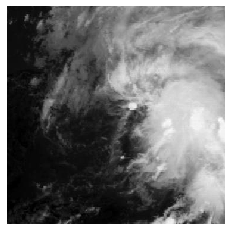

In [12]:
image2 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image2, cmap='gray')
plt.axis("off")
plt.show()

In [13]:
image2.shape

(366, 366)

In [14]:
for dim in range(0,image.shape[2]):
    print('Dimension {}: the maximum is {} and the minimum is {}.'.format(dim, image[dim].max(), image[dim].min()))

Dimension 0: the maximum is 154 and the minimum is 9.
Dimension 1: the maximum is 153 and the minimum is 10.
Dimension 2: the maximum is 146 and the minimum is 10.


In [15]:
if jump_cell == False:
    
    storm_choice = 'rkw'

    img_array = []
    for file in os.listdir(training_dir):
        if storm_choice in file:
            img = cv2.imread(training_dir + '/' + file)
            height, width, layers = img.shape
            size = (width,height)
            img_array.append(img)

    out = cv2.VideoWriter('storm_example.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [16]:
if jump_cell == False:
    
    cap = cv2.VideoCapture('storm_example.avi')

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            print("Stream ended")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cv2.imshow('Storm {}'.format(storm_choice), gray)

        if cv2.waitKey(50) & 0xff==27:
            break

    cap.release()
    cv2.destroyAllWindows()

<a class="anchor" id="data-preparation"></a>
## 3. Data Preparation

In [17]:
df_train = pd.merge(train_features, train_labels, how='inner', on='image_id')

In [18]:
def append_prev_img(df, column):
    
    new_column = list(df[column].values)
    new_column.insert(0,new_column[0])
    new_column = new_column[:-1]
    df['prev_image_id'] = new_column
    
    df.loc[df[column].str.contains(r'000', regex=True), 'prev_image_id'] = np.nan
    
    df['prev_image_id'].fillna(df['image_id'], inplace=True)
    
    return df

In [19]:
df_train.head()

,image_id,storm_id,relative_time,ocean,wind_speed
0,abs_000,abs,0,2,43
1,abs_001,abs,1800,2,44
2,abs_002,abs,5400,2,45
3,abs_003,abs,17999,2,52
4,abs_004,abs,19799,2,53


In [20]:
df_train = append_prev_img(df_train, 'image_id')

In [21]:
def opticalFlowDense(cols, folder, new_folder):
    
    image_prev = cv2.imread(folder + cols[1] + '.jpg')
    image_current = cv2.imread(folder + cols[0] + '.jpg')
    
    gray_prev = cv2.cvtColor(image_prev, cv2.COLOR_RGB2GRAY)
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    
    hsv = np.zeros((366, 366, 3))
    hsv[:,:,1] = cv2.cvtColor(image_current, cv2.COLOR_RGB2HSV)[:,:,1]

#     flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_prev, gray_current,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                             
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    cv2.imwrite(new_folder + cols[0] + '.jpg', rgb_flow)
    
   # return rgb_flow

In [22]:
if os.path.isdir('../image_data/new_train'):
    pass
else:
    os.mkdir('../image_data/new_train')

In [23]:
if jump_cell == False:
    for image_current, image_prev in zip(df_train['image_id'].values, df_train['prev_image_id'].values):
        opticalFlowDense([image_current, image_prev], training_dir+'/', '../image_data/new_train/')

In [24]:
df_train['image_id_jpg'] = np.vectorize(lambda s: s+'.jpg')(df_train['image_id'])

<a class="anchor" id="modeling"></a>
## 4. Modeling

In [25]:
def split_train_val_test(df):
    train, validate, test = np.split(df.sample(frac=1, random_state=42),
                                 [int(.7*len(df)), int(.85*len(df))])
    return train, validate, test

In [26]:
df_train_train, df_train_val, df_train_test = \
            split_train_val_test(df_train)

In [27]:
datagen = ImageDataGenerator(rescale=1./255)

print('Training Set:')
train_generator = datagen.flow_from_dataframe(dataframe = df_train_train,
                                              directory = "../image_data/new_train",
                                              x_col = "image_id_jpg",
                                              y_col = "wind_speed",
                                              class_mode = "raw",
                                              target_size = (32,32),
                                              batch_size = 32)
                                              #shuffle = False)
print()

print('Validation Set:')
val_generator = datagen.flow_from_dataframe(dataframe = df_train_val,
                                              directory = "../image_data/new_train",
                                              x_col = "image_id_jpg",
                                              y_col = "wind_speed",
                                              class_mode = "raw",
                                              target_size = (32,32),
                                              batch_size = 32)
                                              #shuffle = False)
print()

print('Test Set:')
test_generator = datagen.flow_from_dataframe(dataframe = df_train_test,
                                              directory = "../image_data/new_train",
                                              x_col = "image_id_jpg",
                                              y_col = "wind_speed",
                                              class_mode = "raw",
                                              target_size = (32,32),
                                              batch_size = 32)
                                              #shuffle = False)

Training Set:
Found 49179 validated image filenames.

Validation Set:
Found 10539 validated image filenames.

Test Set:
Found 10539 validated image filenames.


In [28]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics

In [29]:
model = Sequential()
model.add(Conv2D(16, kernel_size=3, input_shape=(32,32,3), activation='relu', padding='same'))
model.add(MaxPooling2D(2))
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(64, activation = "relu"))        
model.add(Dense(32, activation = "relu"))
model.add(Dense(16, activation = "relu")) 
model.add(Dense(1, activation='relu'))

model.compile(optimizer=Adam(lr=0.0001), loss='mse')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [30]:
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                          verbose=1, patience=25)

In [31]:
with tensorflow.device(selected_device):
    model.fit_generator(generator = train_generator,
                        epochs = 400,
                        steps_per_epoch = 20,
                        validation_data = val_generator,
                        validation_steps=5,
                        callbacks=[early_stop])

Epoch 1/400
20/20 [==============================] - 7s 366ms/step - loss: 3035.2041 - val_loss: 2939.3863
Epoch 2/400
20/20 [==============================] - 2s 97ms/step - loss: 3043.3823 - val_loss: 2767.7253
Epoch 3/400
20/20 [==============================] - 2s 98ms/step - loss: 2765.9202 - val_loss: 2208.1875
Epoch 4/400
20/20 [==============================] - 2s 105ms/step - loss: 1957.3242 - val_loss: 1154.9458
Epoch 5/400
20/20 [==============================] - 2s 107ms/step - loss: 894.3704 - val_loss: 635.5388
Epoch 6/400
20/20 [==============================] - 3s 125ms/step - loss: 758.4812 - val_loss: 627.8925
Epoch 7/400
20/20 [==============================] - 2s 111ms/step - loss: 772.3091 - val_loss: 632.3630
Epoch 8/400
20/20 [==============================] - 2s 102ms/step - loss: 802.8496 - val_loss: 630.0027
Epoch 9/400
20/20 [==============================] - 2s 102ms/step - loss: 834.3361 - val_loss: 634.9990
Epoch 10/400
20/20 [=============================

In [32]:
ws_test_true = df_train_test['wind_speed'].values

ws_test_preds = model.predict_generator(test_generator)
ws_test_preds = ws_test_preds.reshape(-1)

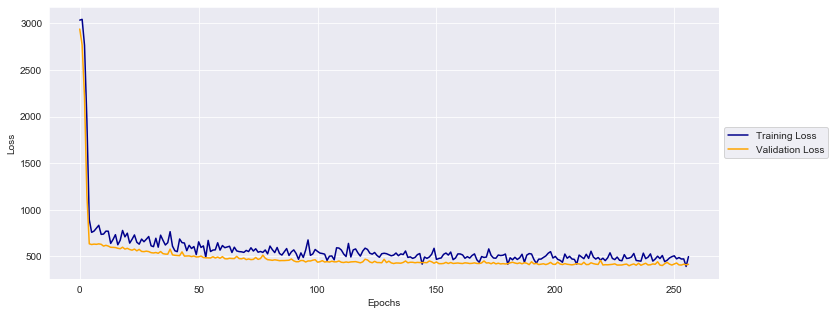

In [33]:
losses = pd.DataFrame(model.history.history)

fig, axes = plt.subplots(figsize=(12,5))

sns.lineplot(x=losses.index,
             y='loss',
             data = losses,
             ax=axes,
             color='darkblue',
             label='Training Loss')

sns.lineplot(x=losses.index,
             y='val_loss',
             data = losses,
             ax=axes,
             color='orange',
             label='Validation Loss')

plt.legend(loc='center left', bbox_to_anchor=(1.0,0.5))

plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.show()

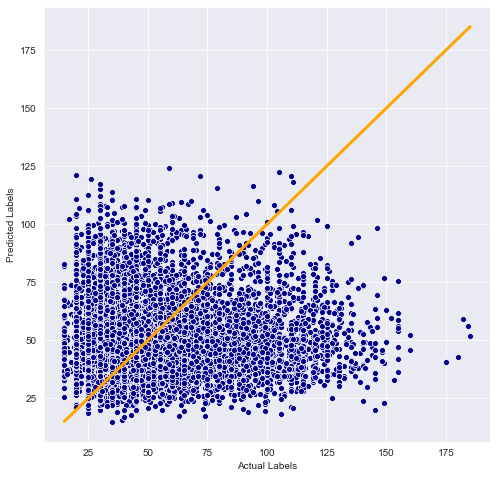

In [34]:
fig, axes = plt.subplots(figsize=(8,8))

sns.scatterplot(x=ws_test_true,
               y=ws_test_preds, ax=axes,
               color='darkblue')
sns.lineplot(x=ws_test_true,
             y=ws_test_true,
             ax=axes,
            color='orange',
            linewidth = 3)

plt.ylabel('Predicted Labels')
plt.xlabel('Actual Labels')

plt.show()

In [35]:
print('Test set\'s RMSE: {}'.format(metrics.mean_squared_error(ws_test_true, ws_test_preds, squared=False)))

Test set's RMSE: 30.9038197369277


<a class="anchor" id="submission"></a>
## 5. Submission

In [37]:
df_sub = pd.read_csv('data/test_set_features.csv')

df_sub['image_id_jpg'] = np.vectorize(lambda s: s+'.jpg')(df_sub['image_id'])

df_sub = append_prev_img(df_sub, 'image_id')

In [38]:
if os.path.isdir('../image_data/new_test'):
    pass
else:
    os.mkdir('../image_data/new_test')

In [39]:
if jump_cell == False:
    for image_current, image_prev in zip(df_sub['image_id'].values, df_sub['prev_image_id'].values):
        opticalFlowDense([image_current, image_prev], test_dir +'/', '../image_data/new_test/')

In [40]:
print('Submission Set:')
submission_generator = datagen.flow_from_dataframe(dataframe = df_sub,
                                              directory = "../image_data/new_test",
                                              x_col = "image_id_jpg",
                                              y_col = None,
                                              class_mode = None,
                                              target_size = (32,32),
                                              batch_size = 32)

Submission Set:
Found 44377 validated image filenames.


In [41]:
with tensorflow.device(selected_device):
    ws_sub_preds = model.predict_generator(submission_generator)
    ws_sub_preds = ws_sub_preds.reshape(-1)

In [42]:
df_sub['wind_speed'] = ws_sub_preds
df_sub['wind_speed'] = np.vectorize(lambda ws: int(ws))(df_sub['wind_speed'])

In [43]:
mov_avg_ison = True

In [44]:
if mov_avg_ison == False:
    
    df_to_sub = df_sub[['image_id','wind_speed']]
    df_to_sub.set_index('image_id', inplace=True)
    
else:
    
    series_mov_avg = []

    for storm in df_sub['storm_id'].unique():
        lista = df_sub[df_sub['storm_id']==storm]['wind_speed'].rolling(window=5, center=True).mean()
        series_mov_avg.append(lista)

    series_mov_avg_flat = [item for sublist in series_mov_avg for item in sublist]

    df_sub['mov_avg'] = series_mov_avg_flat
    df_sub['mov_avg'].fillna(df_sub['wind_speed'], inplace=True)
    df_sub['mov_avg'] = np.vectorize(lambda ws: int(ws))(df_sub['mov_avg'])
    
    df_to_sub = df_sub[['image_id','mov_avg']]
    df_to_sub.set_index('image_id', inplace=True)
    df_to_sub.rename(columns={'mov_avg':'wind_speed'}, inplace=True)

In [45]:
now = datetime.now().strftime("%Y%m%d_%H%M")
df_to_sub.to_csv('submissions/dfsub_'+now+'.csv')

model.save('models/model_'+now+'.h5')

print('Test set\'s RMSE: {}'.format(metrics.mean_squared_error(ws_test_true, ws_test_preds, squared=False)))

Test set's RMSE: 30.9038197369277
